# Process Mining with PM4Py: Inductive Miner Variants

This notebook demonstrates how to create different process models using various inductive miner implementations available in PM4Py. We'll use the filtered XES logs that were created during the preprocessing stage.

In [10]:
# Import required libraries
import os
import pm4py
import matplotlib.pyplot as plt
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator

# Set up the path to the data folder
data_folder = './data/filtered'

## 1. Helper Functions

Let's define some helper functions to load logs, discover models, visualize them, and evaluate their quality.

In [11]:
def load_log(log_file_path):
    """
    Load an XES log file
    
    Args:
        log_file_path: Path to the XES file
        
    Returns:
        PM4Py event log object
    """
    print(f"Loading log: {log_file_path}")
    log = xes_importer.apply(log_file_path)
    print(f"Log loaded with {len(log)} cases and {sum(len(case) for case in log)} events")
    return log

def discover_models(log, variant_name, variant):
    """
    Discover process models using the specified algorithm variant
    
    Args:
        log: PM4Py event log
        variant_name: String name of the variant (for display)
        variant: The actual algorithm variant to use
        
    Returns:
        Tuple containing process tree and Petri net with initial and final markings
    """
    print(f"\nDiscovering models using {variant_name}...")
    
    # Discover process tree
    process_tree = inductive_miner.apply(log, variant=variant)
    
    # Convert to Petri net for visualization and conformance checking
    net, initial_marking, final_marking = pm4py.convert_to_petri_net(process_tree)
    
    return process_tree, net, initial_marking, final_marking

def visualize_models(process_tree, net, initial_marking, final_marking, variant_name, output_folder=None):
    """
    Visualize both process tree and Petri net models
    
    Args:
        process_tree: The process tree model
        net: The Petri net
        initial_marking: Initial marking for the Petri net
        final_marking: Final marking for the Petri net
        variant_name: String name of the variant (for display and filenames)
        output_folder: Folder to save visualizations (if None, just display)
    """
    # Visualize process tree
    pt_gviz = pt_visualizer.apply(process_tree)
    
    # Visualize Petri net
    parameters = {pn_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT: "png"}
    pn_gviz = pn_visualizer.apply(net, initial_marking, final_marking, parameters=parameters)

    # Display visualizations
    if output_folder:
        os.makedirs(output_folder, exist_ok=True)
        pt_visualizer.save(pt_gviz, os.path.join(output_folder, f"process_tree_{variant_name}.png"))
        pn_visualizer.save(pn_gviz, os.path.join(output_folder, f"petri_net_{variant_name}.png"))
        print(f"Visualizations saved to {output_folder}")
    else:
        pt_visualizer.view(pt_gviz)
        pn_visualizer.view(pn_gviz)

def evaluate_model(log, net, initial_marking, final_marking, variant_name):
    """
    Evaluate a process model using the four quality dimensions
    
    Args:
        log: PM4Py event log
        net: The Petri net
        initial_marking: Initial marking for the Petri net
        final_marking: Final marking for the Petri net
        variant_name: String name of the variant (for display)
    
    Returns:
        Dictionary of metrics
    """
    print(f"\nEvaluating {variant_name} model...")
    
    # Compute fitness using token-based replay
    fitness = replay_fitness.evaluate(  
        log=log,
        net=net,
        initial_marking=initial_marking,
        final_marking=final_marking,
        variant=replay_fitness.Variants.TOKEN_BASED
    )


    
    # Compute precision using ETConformance
    precision = precision_evaluator.evaluate(   
        log=log,
        net=net,
        initial_marking=initial_marking,
        final_marking=final_marking,
        variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN
    )


    
    # Compute generalization
    generalization = generalization_evaluator.evaluate(log, net, initial_marking, final_marking)
    
    # Compute simplicity
    simplicity = simplicity_evaluator.evaluate(net)
    
    metrics = {
        'variant': variant_name,
        'fitness': fitness['average_trace_fitness'],
        'precision': precision,
        'generalization': generalization,
        'simplicity': simplicity
    }
    
    print(f"Fitness: {metrics['fitness']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Generalization: {metrics['generalization']:.4f}")
    print(f"Simplicity: {metrics['simplicity']:.4f}")
    
    return metrics

def process_group(log, log_name, output_folder=None):
    """
    Process a log using different inductive miner variants
    
    Args:
        log: PM4Py event log object
        log_name: Name of the log file (without path)
        output_folder: Folder to save visualizations
    
    Returns:
        List of evaluation metrics for each variant
    """
    # If output folder is specified, create a subfolder for this log
    if output_folder:
        group_output_folder = os.path.join(output_folder, log_name.replace('.xes', ''))
        os.makedirs(group_output_folder, exist_ok=True)
    else:
        group_output_folder = None
    
    # List of variants to try
    variants = [
        ('IM', inductive_miner.Variants.IM),
        ('IMf', inductive_miner.Variants.IMf),
        ('IMd', inductive_miner.Variants.IMd)
    ]
    
    all_metrics = []
    
    # Process each variant
    for variant_name, variant in variants:
        # Discover models
        process_tree, net, initial_marking, final_marking = discover_models(log, variant_name, variant)
        
        # Visualize models
        visualize_models(process_tree, net, initial_marking, final_marking, variant_name, group_output_folder)
        
        # Evaluate model
        # metrics = evaluate_model(log, net, initial_marking, final_marking, variant_name)
        # all_metrics.append(metrics)
        
    return all_metrics



## 2. Analyze Each Group

Now let's process each filtered log in the data folder. We'll discover process models using different inductive miner variants for each group.

In [ ]:
# Find all XES files in the data folder
xes_files = [f for f in os.listdir(data_folder) if f.endswith('.xes')]
print(f"Found {len(xes_files)} XES files in {data_folder}:")
for f in xes_files:
    print(f"  - {f}")

# Load all logs into memory once
logs = {}
for xes_file in xes_files:
    group_name = xes_file.replace('.xes', '').replace('group_', '')
    log_path = os.path.join(data_folder, xes_file)
    logs[group_name] = load_log(log_path)
    logs[xes_file] = logs[group_name]  # Also store with original filename as key for backwards compatibility
    
# Create a mapping from filename to group name for easier reference
file_to_group = {xes_file: xes_file.replace('.xes', '').replace('group_', '') for xes_file in xes_files}

Found 4 XES files in ./data/filtered:
  - group_consignment.xes
  - group_2_way.xes
  - group_3_way_after.xes
  - group_3_way_before.xes
Loading log: ./data/filtered/group_consignment.xes


parsing log, completed traces ::   0%|          | 0/11698 [00:00<?, ?it/s]

Log loaded with 11698 cases and 26953 events
Loading log: ./data/filtered/group_2_way.xes


parsing log, completed traces ::   0%|          | 0/289 [00:00<?, ?it/s]

Log loaded with 289 cases and 765 events
Loading log: ./data/filtered/group_3_way_after.xes


parsing log, completed traces ::   0%|          | 0/13035 [00:00<?, ?it/s]

In [ ]:
# Find all XES files in the data folder
xes_files = [f for f in os.listdir(data_folder) if f.endswith('.xes')]
print(f"Found {len(xes_files)} XES files in {data_folder}:")
for f in xes_files:
    print(f"  - {f}")

# Create output folder for visualizations
output_folder = './output'
os.makedirs(output_folder, exist_ok=True)

# Process each group using preloaded logs
all_results = {}
for xes_file in xes_files:
    print(f"\n{'='*50}")
    print(f"Processing {xes_file}")
    print(f"{'='*50}")
    group_metrics = process_group(logs[xes_file], xes_file, output_folder)
    all_results[xes_file] = group_metrics

Found 4 XES files in ./data/filtered:
  - group_consignment.xes
  - group_2_way.xes
  - group_3_way_after.xes
  - group_3_way_before.xes

Processing group_consignment.xes

Discovering models using IM...
Visualizations saved to ./output/group_consignment

Discovering models using IMf...
Visualizations saved to ./output/group_consignment

Discovering models using IMf...
Visualizations saved to ./output/group_consignment

Discovering models using IMd...
Visualizations saved to ./output/group_consignment

Discovering models using IMd...
Visualizations saved to ./output/group_consignment

Processing group_2_way.xes

Discovering models using IM...
Visualizations saved to ./output/group_2_way

Discovering models using IMf...
Visualizations saved to ./output/group_consignment

Processing group_2_way.xes

Discovering models using IM...
Visualizations saved to ./output/group_2_way

Discovering models using IMf...
Visualizations saved to ./output/group_2_way

Discovering models using IMd...
Visua

KeyboardInterrupt: 

## 2. Compliance Check per Classification

This analysis checks whether each purchase order case in the event log complies with the expected behavior defined by its item classification, based on the BPI Challenge 2019 documentation.

3-way match, invoice after GR:
The invoice is recorded after goods receipt, and both must exist in the trace (GR-based IV = true, Goods Receipt = true).

3-way match, invoice before GR:
The invoice can be recorded before goods receipt, but both events are still expected in the trace (GR-based IV = false, Goods Receipt = true).

2-way match:
Only an invoice is expected — no goods receipt is required (GR-based IV = false, Goods Receipt = false).

Consignment:
Goods are received but no invoice is expected or allowed (Goods Receipt = true, GR-based IV = false, and item type is consignment).

NOTE: We check event order based on the first occurrence of each activity in a case. This may miss edge cases with repeated events, but offers a practical balance between accuracy and simplicity.


Compliance Results:
consignment:
  ✅ Compliant: 11075 cases (94.67%)
  ❌ Non-compliant: 623 cases
  Total: 11698 cases
--------------------------------------------------
2_way:
  ✅ Compliant: 52 cases (17.99%)
  ❌ Non-compliant: 237 cases
  Total: 289 cases
--------------------------------------------------
3_way_after:
  ✅ Compliant: 9372 cases (71.90%)
  ❌ Non-compliant: 3663 cases
  Total: 13035 cases
--------------------------------------------------
3_way_before:
  ✅ Compliant: 12860 cases (7.36%)
  ❌ Non-compliant: 161985 cases
  Total: 174845 cases
--------------------------------------------------


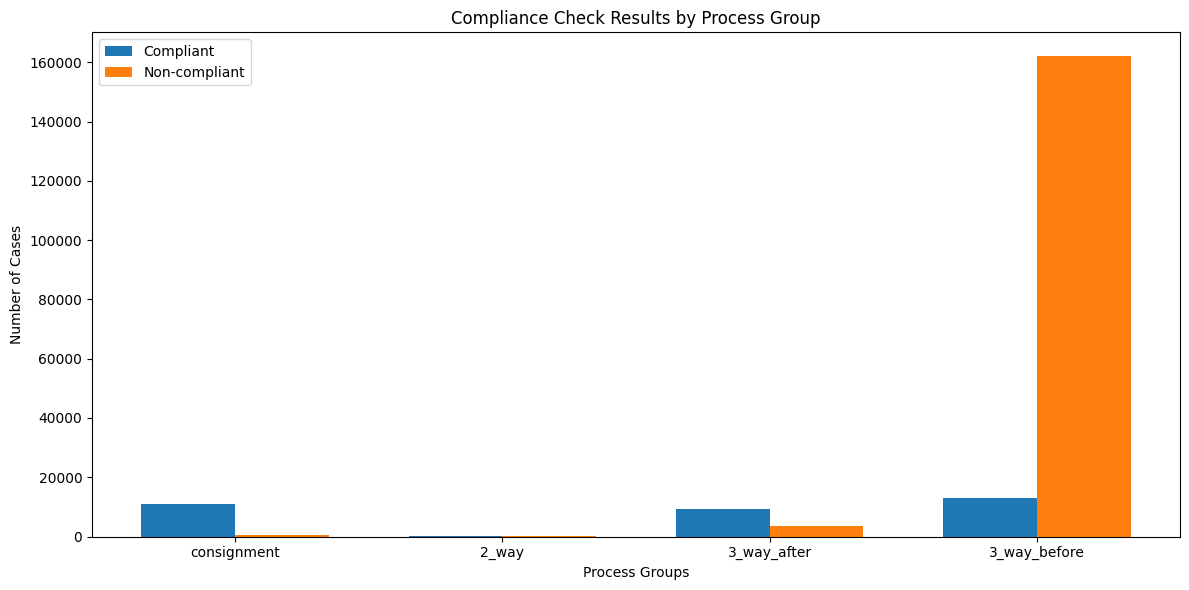

In [ ]:
def check_case_compliance(log_files, preloaded_logs):
    """
    Check whether each filtered log complies with the expected behavior
    for its process group.

    Args:
        log_files: List of log file names in the filtered folder
        preloaded_logs: Dictionary of preloaded logs
    
    Returns:
        A dictionary containing counts of compliant and non-compliant cases per category.
    """
    # Initialize compliance results
    compliance_results = {}
    
    for log_file in log_files:
        # Extract group name from filename
        group_name = log_file.replace('.xes', '').replace('group_', '')
        
        # Use preloaded log
        log = preloaded_logs[log_file]
        
        # Initialize counters for this group
        compliant = 0
        non_compliant = 0
        
        # Check each case according to its group's specific rules
        for case in log:
            events = [e["concept:name"] for e in case]
            
            # 3-way match, invoice after goods receipt
            if "3_way_after" in log_file:
                if "Record Goods Receipt" in events and "Record Invoice Receipt" in events:
                    if events.index("Record Goods Receipt") < events.index("Record Invoice Receipt"):
                        compliant += 1
                    else:
                        non_compliant += 1  # wrong order
                else:
                    non_compliant += 1  # missing steps
            
            # 3-way match, invoice before goods receipt
            elif "3_way_before" in log_file:
                if "Record Invoice Receipt" in events and "Record Goods Receipt" in events:
                    if events.index("Record Invoice Receipt") < events.index("Record Goods Receipt"):
                        compliant += 1
                    else:
                        non_compliant += 1  # wrong order
                else:
                    non_compliant += 1  # missing steps
            
            # 2-way match
            elif "2_way" in log_file:
                if "Record Invoice Receipt" in events and "Record Goods Receipt" not in events:
                    compliant += 1
                else:
                    non_compliant += 1
            
            # Consignment
            elif "consignment" in log_file:
                if "Record Goods Receipt" in events and "Record Invoice Receipt" not in events:
                    compliant += 1
                else:
                    non_compliant += 1
        
        # Store results for this group
        compliance_results[group_name] = {
            "compliant": compliant,
            "non_compliant": non_compliant,
            "total": compliant + non_compliant,
            "compliance_rate": compliant / (compliant + non_compliant) * 100 if (compliant + non_compliant) > 0 else 0
        }
    
    return compliance_results

# Check compliance for all filtered logs using preloaded logs
compliance_results = check_case_compliance(xes_files, logs)

# Display results
print("\nCompliance Results:")
print("=" * 50)
for group, stats in compliance_results.items():
    print(f"{group}:")
    print(f"  ✅ Compliant: {stats['compliant']} cases ({stats['compliance_rate']:.2f}%)")
    print(f"  ❌ Non-compliant: {stats['non_compliant']} cases")
    print(f"  Total: {stats['total']} cases")
    print("-" * 50)

# Visualize results
plt.figure(figsize=(12, 6))
groups = list(compliance_results.keys())
compliant = [compliance_results[g]['compliant'] for g in groups]
non_compliant = [compliance_results[g]['non_compliant'] for g in groups]

x = range(len(groups))
width = 0.35

plt.bar(x, compliant, width, label='Compliant')
plt.bar([i + width for i in x], non_compliant, width, label='Non-compliant')

plt.xlabel('Process Groups')
plt.ylabel('Number of Cases')
plt.title('Compliance Check Results by Process Group')
plt.xticks([i + width/2 for i in x], groups)
plt.legend()

plt.tight_layout()
plt.show()


## 3. Compare Results

Let's create a summary view to compare the performance of different inductive miner variants across the different process groups.

def check_case_compliance(log_files, preloaded_logs):
    """
    Check whether each filtered log complies with the expected behavior
    for its process group.

    Args:
        log_files: List of log file names in the filtered folder
        preloaded_logs: Dictionary of preloaded logs
    
    Returns:
        A dictionary containing counts of compliant and non-compliant cases per category.
    """
    # Initialize compliance results
    compliance_results = {}
    
    for log_file in log_files:
        # Extract group name from filename
        group_name = log_file.replace('.xes', '').replace('group_', '')
        
        # Use the preloaded log
        log = preloaded_logs[log_file]
        
        # Initialize counters for this group
        compliant = 0
        non_compliant = 0
        
        # Check each case according to its group's specific rules
        for case in log:
            events = [e["concept:name"] for e in case]
            
            # 3-way match, invoice after goods receipt
            if "3_way_after" in log_file:
                if "Record Goods Receipt" in events and "Record Invoice Receipt" in events:
                    if events.index("Record Goods Receipt") < events.index("Record Invoice Receipt"):
                        compliant += 1
                    else:
                        non_compliant += 1  # wrong order
                else:
                    non_compliant += 1  # missing steps
            
            # 3-way match, invoice before goods receipt
            elif "3_way_before" in log_file:
                if "Record Invoice Receipt" in events and "Record Goods Receipt" in events:
                    if events.index("Record Invoice Receipt") < events.index("Record Goods Receipt"):
                        compliant += 1
                    else:
                        non_compliant += 1  # wrong order
                else:
                    non_compliant += 1  # missing steps
            
            # 2-way match
            elif "2_way" in log_file:
                if "Record Invoice Receipt" in events and "Record Goods Receipt" not in events:
                    compliant += 1
                else:
                    non_compliant += 1
            
            # Consignment
            elif "consignment" in log_file:
                if "Record Goods Receipt" in events and "Record Invoice Receipt" not in events:
                    compliant += 1
                else:
                    non_compliant += 1
        
        # Store results for this group
        compliance_results[group_name] = {
            "compliant": compliant,
            "non_compliant": non_compliant,
            "total": compliant + non_compliant,
            "compliance_rate": compliant / (compliant + non_compliant) * 100 if (compliant + non_compliant) > 0 else 0
        }
    
    return compliance_results

# Check compliance for all filtered logs using preloaded logs
compliance_results = check_case_compliance(xes_files, logs)

# Display results
print("\nCompliance Results:")
print("=" * 50)
for group, stats in compliance_results.items():
    print(f"{group}:")
    print(f"  ✅ Compliant: {stats['compliant']} cases ({stats['compliance_rate']:.2f}%)")
    print(f"  ❌ Non-compliant: {stats['non_compliant']} cases")
    print(f"  Total: {stats['total']} cases")
    print("-" * 50)

# Visualize results
plt.figure(figsize=(12, 6))
groups = list(compliance_results.keys())
compliant = [compliance_results[g]['compliant'] for g in groups]
non_compliant = [compliance_results[g]['non_compliant'] for g in groups]

x = range(len(groups))
width = 0.35

plt.bar(x, compliant, width, label='Compliant')
plt.bar([i + width for i in x], non_compliant, width, label='Non-compliant')

plt.xlabel('Process Groups')
plt.ylabel('Number of Cases')
plt.title('Compliance Check Results by Process Group')
plt.xticks([i + width/2 for i in x], groups)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a dataframe with all results
results_df = []
for log_name, metrics_list in all_results.items():
    for metrics in metrics_list:
        metrics_copy = metrics.copy()
        metrics_copy['log'] = log_name.replace('.xes', '').replace('group_', '')
        results_df.append(metrics_copy)

results_df = pd.DataFrame(results_df)
print(results_df)

# Plot the results using a heatmap for each metric
metrics = ['fitness', 'precision', 'generalization', 'simplicity']

fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 4*len(metrics)))

for i, metric in enumerate(metrics):
    pivot_df = results_df.pivot(index='log', columns='variant', values=metric)
    sns.heatmap(pivot_df, annot=True, cmap='YlGnBu', ax=axes[i])
    axes[i].set_title(f'{metric.capitalize()} by variant and log')

plt.tight_layout()
plt.show()

## 4. Detailed Analysis of the "2-way match" Process

Let's focus on the "2-way match" process group and analyze it in more detail.

In [ ]:
# Use the preloaded 2-way match log
two_way_log = logs['2_way']

# Get some basic statistics
print(f"Number of cases: {len(two_way_log)}")
print(f"Number of events: {sum(len(case) for case in two_way_log)}")
print(f"Average events per case: {sum(len(case) for case in two_way_log) / len(two_way_log):.2f}")

# Get the most frequent variants
variants = pm4py.get_variants(two_way_log)
print(f"Number of variants: {len(variants)}")

# Display top 5 variants
variant_count = [(count, trace) for trace, count in variants.items()]
variant_count.sort(reverse=True)
print("\nTop 5 variants:")
for i, (count, trace) in enumerate(variant_count[:5]):
    activities = [event['concept:name'] for event in trace]
    print(f"{i+1}. Count: {count} - Activities: {' → '.join(activities)}")

# Apply the IMf variant (usually good balance between precision and generalization)
process_tree = inductive_miner.apply_tree(two_way_log, variant=inductive_miner.Variants.IMF)
net, initial_marking, final_marking = pm4py.convert_to_petri_net(process_tree)

# Visualize the process tree and Petri net
pt_gviz = pt_visualizer.apply(process_tree)
pt_visualizer.view(pt_gviz)

# Perform more detailed conformance checking
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay
replayed_traces = token_replay.apply(two_way_log, net, initial_marking, final_marking)

# Analyze conformance results
conforming_traces = [trace for trace in replayed_traces if trace['trace_is_fit']]
print(f"Conforming traces: {len(conforming_traces)} out of {len(replayed_traces)} ({len(conforming_traces)/len(replayed_traces)*100:.2f}%)")

# Identify problematic transitions if any
all_transitions = set()
activated_transitions = set()
missing_transitions = set()

for trace in replayed_traces:
    for trans in trace['activated_transitions']:
        all_transitions.add(trans.name)
        activated_transitions.add(trans.name)
    for trans in trace['missing_tokens_transitions']:
        all_transitions.add(trans.name)
        missing_transitions.add(trans.name)

print("\nActivated transitions:", len(activated_transitions))
print("Missing transitions:", len(missing_transitions))
if missing_transitions:
    print("Problematic transitions:", missing_transitions)

## 5. Comparing Different Process Groups

Let's now compare the different process groups to understand how they differ from each other.

# Use the preloaded 2-way match log
two_way_log = logs['2_way']

# Get some basic statistics
print(f"Number of cases: {len(two_way_log)}")
print(f"Number of events: {sum(len(case) for case in two_way_log)}")
print(f"Average events per case: {sum(len(case) for case in two_way_log) / len(two_way_log):.2f}")

# Get the most frequent variants
variants = pm4py.get_variants(two_way_log)
print(f"Number of variants: {len(variants)}")

# Display top 5 variants
variant_count = [(count, trace) for trace, count in variants.items()]
variant_count.sort(reverse=True)
print("\nTop 5 variants:")
for i, (count, trace) in enumerate(variant_count[:5]):
    activities = [event['concept:name'] for event in trace]
    print(f"{i+1}. Count: {count} - Activities: {' → '.join(activities)}")

# Apply the IMf variant (usually good balance between precision and generalization)
process_tree = inductive_miner.apply_tree(two_way_log, variant=inductive_miner.Variants.IMF)
net, initial_marking, final_marking = pm4py.convert_to_petri_net(process_tree)

# Visualize the process tree and Petri net
pt_gviz = pt_visualizer.apply(process_tree)
pt_visualizer.view(pt_gviz)

# Perform more detailed conformance checking
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay
replayed_traces = token_replay.apply(two_way_log, net, initial_marking, final_marking)

# Analyze conformance results
conforming_traces = [trace for trace in replayed_traces if trace['trace_is_fit']]
print(f"Conforming traces: {len(conforming_traces)} out of {len(replayed_traces)} ({len(conforming_traces)/len(replayed_traces)*100:.2f}%)")

# Identify problematic transitions if any
all_transitions = set()
activated_transitions = set()
missing_transitions = set()

for trace in replayed_traces:
    for trans in trace['activated_transitions']:
        all_transitions.add(trans.name)
        activated_transitions.add(trans.name)
    for trans in trace['missing_tokens_transitions']:
        all_transitions.add(trans.name)
        missing_transitions.add(trans.name)

print("\nActivated transitions:", len(activated_transitions))
print("Missing transitions:", len(missing_transitions))
if missing_transitions:
    print("Problematic transitions:", missing_transitions)

In [ ]:
# Logs are already loaded, we can use them directly

# Compare number of variants and activities
for group_name, log in logs.items():
    variants = pm4py.get_variants(log)
    activities = pm4py.get_event_attribute_values(log, "concept:name")
    
    print(f"\nGroup: {group_name}")
    print(f"  Cases: {len(log)}")
    print(f"  Events: {sum(len(case) for case in log)}")
    print(f"  Variants: {len(variants)}")
    print(f"  Activities: {len(activities)}")
    print(f"  Events per case: {sum(len(case) for case in log) / len(log):.2f}")

# Identify common and unique activities across groups
all_activities = {}
for group_name, log in logs.items():
    activities = set(pm4py.get_event_attribute_values(log, "concept:name").keys())
    all_activities[group_name] = activities

# Find activities that appear in all groups
if len(all_activities) > 1:
    common_activities = set.intersection(*all_activities.values())
    print(f"\nCommon activities across all groups ({len(common_activities)}):")
    print(", ".join(sorted(common_activities)))
    
    # Find activities unique to each group
    for group_name, activities in all_activities.items():
        unique_activities = activities - set.union(*(set(acts) for g, acts in all_activities.items() if g != group_name))
        print(f"\nActivities unique to {group_name} ({len(unique_activities)}):")
        if unique_activities:
            print(", ".join(sorted(unique_activities)))
        else:
            print("None")

## 6. Advanced Process Mining: Directly-Follows Graphs

Let's visualize the directly-follows graphs (DFGs) for each process group, which can provide a simpler view of the process.

# Logs are already loaded, we can use them directly

# Compare number of variants and activities
for group_name, log in logs.items():
    # Skip entries with full filenames
    if group_name in xes_files:
        continue
        
    variants = pm4py.get_variants(log)
    activities = pm4py.get_event_attribute_values(log, "concept:name")
    
    print(f"\nGroup: {group_name}")
    print(f"  Cases: {len(log)}")
    print(f"  Events: {sum(len(case) for case in log)}")
    print(f"  Variants: {len(variants)}")
    print(f"  Activities: {len(activities)}")
    print(f"  Events per case: {sum(len(case) for case in log) / len(log):.2f}")

# Identify common and unique activities across groups
all_activities = {}
for group_name, log in logs.items():
    # Skip entries with full filenames
    if group_name in xes_files:
        continue
        
    activities = set(pm4py.get_event_attribute_values(log, "concept:name").keys())
    all_activities[group_name] = activities

# Find activities that appear in all groups
if len(all_activities) > 1:
    common_activities = set.intersection(*all_activities.values())
    print(f"\nCommon activities across all groups ({len(common_activities)}):")
    print(", ".join(sorted(common_activities)))
    
    # Find activities unique to each group
    for group_name, activities in all_activities.items():
        unique_activities = activities - set.union(*(set(acts) for g, acts in all_activities.items() if g != group_name))
        print(f"\nActivities unique to {group_name} ({len(unique_activities)}):")
        if unique_activities:
            print(", ".join(sorted(unique_activities)))
        else:
            print("None")

In [ ]:
from pm4py.visualization.dfg import visualizer as dfg_visualizer

# For each log, create and visualize a directly-follows graph
for group_name, log in logs.items():
    # Skip entries with full filenames
    if group_name in xes_files:
        continue
        
    print(f"\nGenerating DFG for {group_name}...")
    
    # Discover directly-follows graph
    dfg, start_activities, end_activities = pm4py.discover_directly_follows_graph(log)
    
    # Visualize DFG
    parameters = {dfg_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
    gviz = dfg_visualizer.apply(dfg, start_activities, end_activities, parameters=parameters)
    
    # Save to file
    output_path = os.path.join(output_folder, f"dfg_{group_name}.png")
    dfg_visualizer.save(gviz, output_path)
    
    print(f"DFG visualization saved to {output_path}")
    
    # Just for display in the notebook
    dfg_visualizer.view(gviz)

    # Also generate a performance DFG to show time differences
    perf_dfg, perf_sa, perf_ea = pm4py.discover_performance_directly_follows_graph(log)
    
    # Visualize performance DFG
    perf_gviz = dfg_visualizer.apply(perf_dfg, perf_sa, perf_ea, variant=dfg_visualizer.Variants.PERFORMANCE, 
                                 parameters=parameters)
    
    # Save to file
    perf_output_path = os.path.join(output_folder, f"perf_dfg_{group_name}.png")
    dfg_visualizer.save(perf_gviz, perf_output_path)
    
    print(f"Performance DFG visualization saved to {perf_output_path}")
    
    # Just for display in the notebook
    dfg_visualizer.view(perf_gviz)

## 7. Conclusion

In this notebook, we have:

1. Loaded and analyzed filtered XES logs for different process groups
2. Used various inductive miner variants to discover process models
3. Evaluated the quality of these models using standard metrics
4. Compared different process groups
5. Visualized models as process trees, Petri nets, and directly-follows graphs

The different inductive miner variants offer different trade-offs:
- IM (Inductive Miner): Balanced approach, guarantees sound models
- IMf (Inductive Miner - infrequent): Filters out infrequent behavior
- IMd (Inductive Miner - directly follows): Uses the directly-follows abstraction
- IM_CLEAN: More aggressive filtering approach to create simpler models

For further analysis, you might consider:
- Analyzing the resource perspective (who performs which activities)
- Analyzing the time perspective (bottlenecks, throughput times)
- Building predictive models based on these discovered processes

from pm4py.visualization.dfg import visualizer as dfg_visualizer

# For each log, create and visualize a directly-follows graph
for group_name, log in logs.items():
    # Skip entries with full filenames
    if group_name in xes_files:
        continue
        
    print(f"\nGenerating DFG for {group_name}...")
    
    # Discover directly-follows graph
    dfg, start_activities, end_activities = pm4py.discover_directly_follows_graph(log)
    
    # Visualize DFG
    parameters = {dfg_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
    gviz = dfg_visualizer.apply(dfg, start_activities, end_activities, parameters=parameters)
    
    # Save to file
    output_path = os.path.join(output_folder, f"dfg_{group_name}.png")
    dfg_visualizer.save(gviz, output_path)
    
    print(f"DFG visualization saved to {output_path}")
    
    # Just for display in the notebook
    dfg_visualizer.view(gviz)

    # Also generate a performance DFG to show time differences
    perf_dfg, perf_sa, perf_ea = pm4py.discover_performance_directly_follows_graph(log)
    
    # Visualize performance DFG
    perf_gviz = dfg_visualizer.apply(perf_dfg, perf_sa, perf_ea, variant=dfg_visualizer.Variants.PERFORMANCE, 
                                 parameters=parameters)
    
    # Save to file
    perf_output_path = os.path.join(output_folder, f"perf_dfg_{group_name}.png")
    dfg_visualizer.save(perf_gviz, perf_output_path)
    
    print(f"Performance DFG visualization saved to {perf_output_path}")
    
    # Just for display in the notebook
    dfg_visualizer.view(perf_gviz)